# Multitask GP Regression

## Introduction

Multitask regression, introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a lookup table containing inter-task covariance.

In [11]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [12]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

print(f"train_y: {train_y}")

train_y: tensor([[ 0.4056,  0.9498],
        [ 0.1197,  1.0630],
        [ 0.1468,  1.0162],
        [ 0.0703,  0.7839],
        [ 0.4519,  1.0862],
        [ 0.4143,  1.2236],
        [ 0.5995,  1.1463],
        [ 0.3914,  0.7685],
        [ 0.1636,  0.6165],
        [ 0.4460,  0.9654],
        [ 0.5022,  0.7441],
        [ 0.9060,  0.9157],
        [ 0.9063,  0.8109],
        [ 0.5730,  0.9354],
        [ 0.5334,  1.0287],
        [ 0.9573,  0.7919],
        [ 0.7981,  0.3798],
        [ 0.5423,  0.5167],
        [ 1.0901,  0.3808],
        [ 0.8420,  0.2297],
        [ 1.0325,  0.3459],
        [ 1.2131,  0.2766],
        [ 0.7990,  0.2216],
        [ 0.7628,  0.1609],
        [ 1.0062,  0.0706],
        [ 1.0006,  0.0538],
        [ 0.9984, -0.0486],
        [ 0.9861, -0.1024],
        [ 0.7961, -0.3228],
        [ 0.9922, -0.3060],
        [ 0.7381, -0.3459],
        [ 0.6552, -0.4091],
        [ 1.1529, -0.7053],
        [ 1.1206, -0.7721],
        [ 0.8636, -0.6323],
        [ 0

## Define a multitask model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `MultitaskKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

You may also notice that we don't use a ScaleKernel, since the MultitaskKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [13]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [18]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/200 - Loss: -0.104
Iter 2/200 - Loss: -0.113
Iter 3/200 - Loss: -0.120
Iter 4/200 - Loss: -0.121
Iter 5/200 - Loss: -0.119
Iter 6/200 - Loss: -0.118
Iter 7/200 - Loss: -0.117
Iter 8/200 - Loss: -0.118
Iter 9/200 - Loss: -0.118
Iter 10/200 - Loss: -0.120
Iter 11/200 - Loss: -0.121
Iter 12/200 - Loss: -0.122
Iter 13/200 - Loss: -0.121
Iter 14/200 - Loss: -0.121
Iter 15/200 - Loss: -0.120
Iter 16/200 - Loss: -0.120
Iter 17/200 - Loss: -0.120
Iter 18/200 - Loss: -0.120
Iter 19/200 - Loss: -0.121
Iter 20/200 - Loss: -0.122
Iter 21/200 - Loss: -0.122
Iter 22/200 - Loss: -0.122
Iter 23/200 - Loss: -0.122
Iter 24/200 - Loss: -0.121
Iter 25/200 - Loss: -0.121
Iter 26/200 - Loss: -0.121
Iter 27/200 - Loss: -0.121
Iter 28/200 - Loss: -0.121
Iter 29/200 - Loss: -0.122
Iter 30/200 - Loss: -0.122
Iter 31/200 - Loss: -0.122
Iter 32/200 - Loss: -0.122
Iter 33/200 - Loss: -0.122
Iter 34/200 - Loss: -0.122
Iter 35/200 - Loss: -0.122
Iter 36/200 - Loss: -0.122
Iter 37/200 - Loss: -0.122
Iter 38/20

### Make predictions with the model

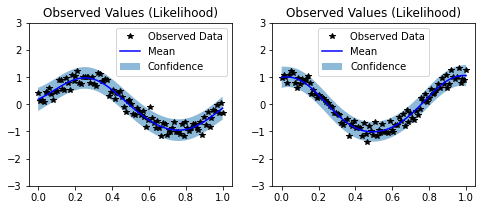

In [19]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None